## Tổng quan về GMM trong bài toán phân cụm

### 1. Giới thiệu về GMM

Gaussian Mixture Model (GMM) là một mô hình xác suất dùng để mô hình hóa phân phối dữ liệu như là sự kết hợp của nhiều phân phối chuẩn (Gaussian). Trong bài toán phân cụm, GMM tìm cách gán mỗi điểm dữ liệu vào một cụm dựa trên xác suất thuộc về các phân phối khác nhau.

Khác với KMeans – chỉ gán mỗi điểm vào **một cụm duy nhất**, GMM cho phép **xác suất mềm** (soft assignment), nghĩa là một điểm có thể thuộc về nhiều cụm với các xác suất khác nhau.


### 2. Ưu điểm của GMM

- **Phân cụm mềm**: Cho phép biểu diễn tính không chắc chắn trong phân cụm.
- **Phù hợp với phân cụm phi tuyến**: Có thể mô hình hóa các cụm có hình dạng ellipsoid, không chỉ hình cầu như KMeans.
- **Linh hoạt hơn**: Mỗi cụm có thể có phương sai, trung bình riêng biệt → mô hình phù hợp hơn với dữ liệu thực tế có phân bố phức tạp.


### 3. Nhược điểm

- **Nhạy cảm với khởi tạo và outlier**.
- **Phức tạp tính toán hơn** so với KMeans do sử dụng thuật toán EM (Expectation-Maximization).
- Cần chọn số lượng cụm phù hợp để tránh underfitting hoặc overfitting.

### 4. Quy trình hoạt động

1. **Khởi tạo** các tham số cho mỗi phân phối Gaussian (trung tâm, ma trận hiệp phương sai, trọng số cụm).
2. **Expectation step (E-step)**: Tính xác suất mỗi điểm thuộc về mỗi Gaussian.
3. **Maximization step (M-step)**: Cập nhật lại các tham số của Gaussian dựa trên xác suất vừa tính.
4. **Lặp lại** E-step và M-step cho đến khi hội tụ.


### 5. Ứng dụng trong bài toán

Trong bài toán phân cụm dữ liệu ô tô:
- GMM giúp nhận diện các cụm xe có các đặc điểm gần nhau về giá, thương hiệu, kích thước động cơ,...
- So với KMeans, GMM cho ranh giới mềm hơn, thể hiện tốt hơn các cụm chồng lấn trong không gian dữ liệu.


---
##  Chuẩn bị và tiền xử lý dữ liệu

Trong bước này, chúng ta thực hiện các thao tác quan trọng để chuẩn bị dữ liệu đầu vào cho mô hình phân cụm.


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import seaborn as sns

df = pd.read_csv("encode_data.csv") 

X = df[["Price_segment", "Brand_encoded", "Engine Size", "Odometer", "Interior color_encoded", "Body Style_encoded", "Drive type_encoded"]]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)


---
## Chọn số cụm tối ưu bằng Silhouette Score

Trong bước này, chúng ta thử nhiều giá trị khác nhau của `k` (số cụm) để tìm ra số cụm tối ưu cho thuật toán **GGM** dựa trên chỉ số **Silhouette Score**.

Silhouette Score đo lường mức độ phù hợp của một điểm dữ liệu với cụm mà nó thuộc về so với các cụm khác. Giá trị càng gần 1 thì phân cụm càng tốt.

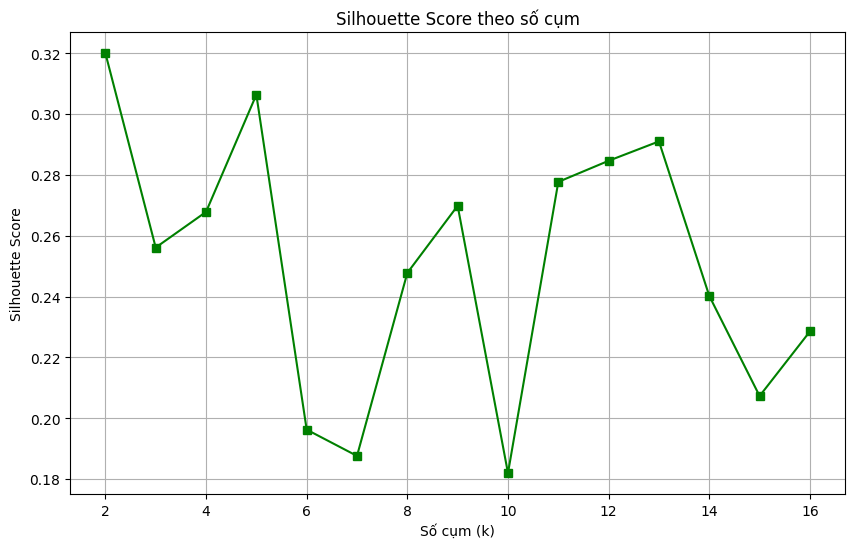

In [ ]:

# Khởi tạo các biến để tìm số cụm tối ưu theo BIC
lowest_bic = float('inf')
best_gmm = None
best_k = 0
bic_scores = []

silhouette_scores = []

for k in range(2, 17):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_train_scaled)
    bic = gmm.bic(X_train_scaled)
    bic_scores.append(bic)
    
    labels = gmm.predict(X_train_scaled)
    sil = silhouette_score(X_train_scaled, labels)
    silhouette_scores.append(sil)
    
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k


plt.figure(figsize=(10, 6))
plt.plot(range(2, 17), silhouette_scores, marker='s', color='green')
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score theo số cụm")
plt.grid(True)
plt.show()



---
## Trực quan hóa kết quả phân cụm GGM bằng PCA


###  Mục tiêu:
Do dữ liệu ban đầu có nhiều chiều (features), việc trực quan hóa là rất khó. Vì vậy, ta sử dụng **PCA (Principal Component Analysis)** để giảm chiều dữ liệu từ **n chiều → 2 chiều**, giúp dễ dàng biểu diễn trên biểu đồ.


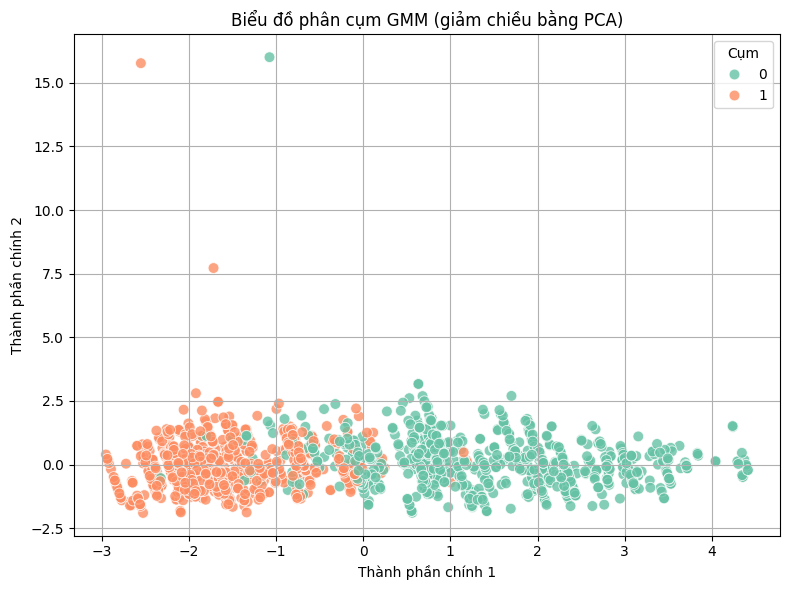

In [66]:

best_gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
best_gmm.fit(X_train_scaled)

# Fit mô hình KMeans
labels = best_gmm.fit_predict(X_train_scaled)  # X_scaled là dữ liệu đã chuẩn hóa

# Giảm chiều với PCA (từ nhiều chiều → 2 chiều)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Vẽ biểu đồ cụm
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=60, alpha=0.8
)
plt.title("Biểu đồ phân cụm GMM (giảm chiều bằng PCA)")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.legend(title='Cụm')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:

# Gán nhãn phân cụm cho dữ liệu
cluster_labels = best_gmm.predict(X_train_scaled)

# Đánh giá chất lượng phân cụm bằng Silhouette Score
sil_score = silhouette_score(X_train_scaled, cluster_labels)
print(f"Silhouette score: {sil_score:.3f}")

# Thêm nhãn cụm vào DataFrame gốc
X['Cluster'] = cluster_labels

# Hiển thị thống kê trung bình theo từng cụm
grouped_stats = X.groupby('Cluster')[
    ["Price_segment", "Brand_encoded", "Engine Size", "Odometer", 
     "Interior color_encoded", "Body Style_encoded", "Drive type_encoded"]
].mean()

print(grouped_stats)

Silhouette score: 0.320
         Price_segment  Brand_encoded  Engine Size      Odometer  \
Cluster                                                            
0             3.278481       2.913873     2.174223  30068.703107   
1             1.597340       1.914209     1.581016  32718.244256   

         Interior color_encoded  Body Style_encoded  Drive type_encoded  
Cluster                                                                  
0                      2.703704            2.645668            3.087752  
1                      2.205332            2.264165            1.797730  


C:\Users\a\AppData\Local\Temp\ipykernel_26300\344770451.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = cluster_labels


---
## Phân tích trung bình đặc trưng theo từng cụm

Sau khi thực hiện phân cụm dữ liệu và lưu nhãn cụm vào cột `Cluster`, bước tiếp theo là trực quan hóa **giá trị trung bình của từng đặc trưng số theo từng cụm** để hiểu rõ hơn các cụm khác nhau như thế nào.



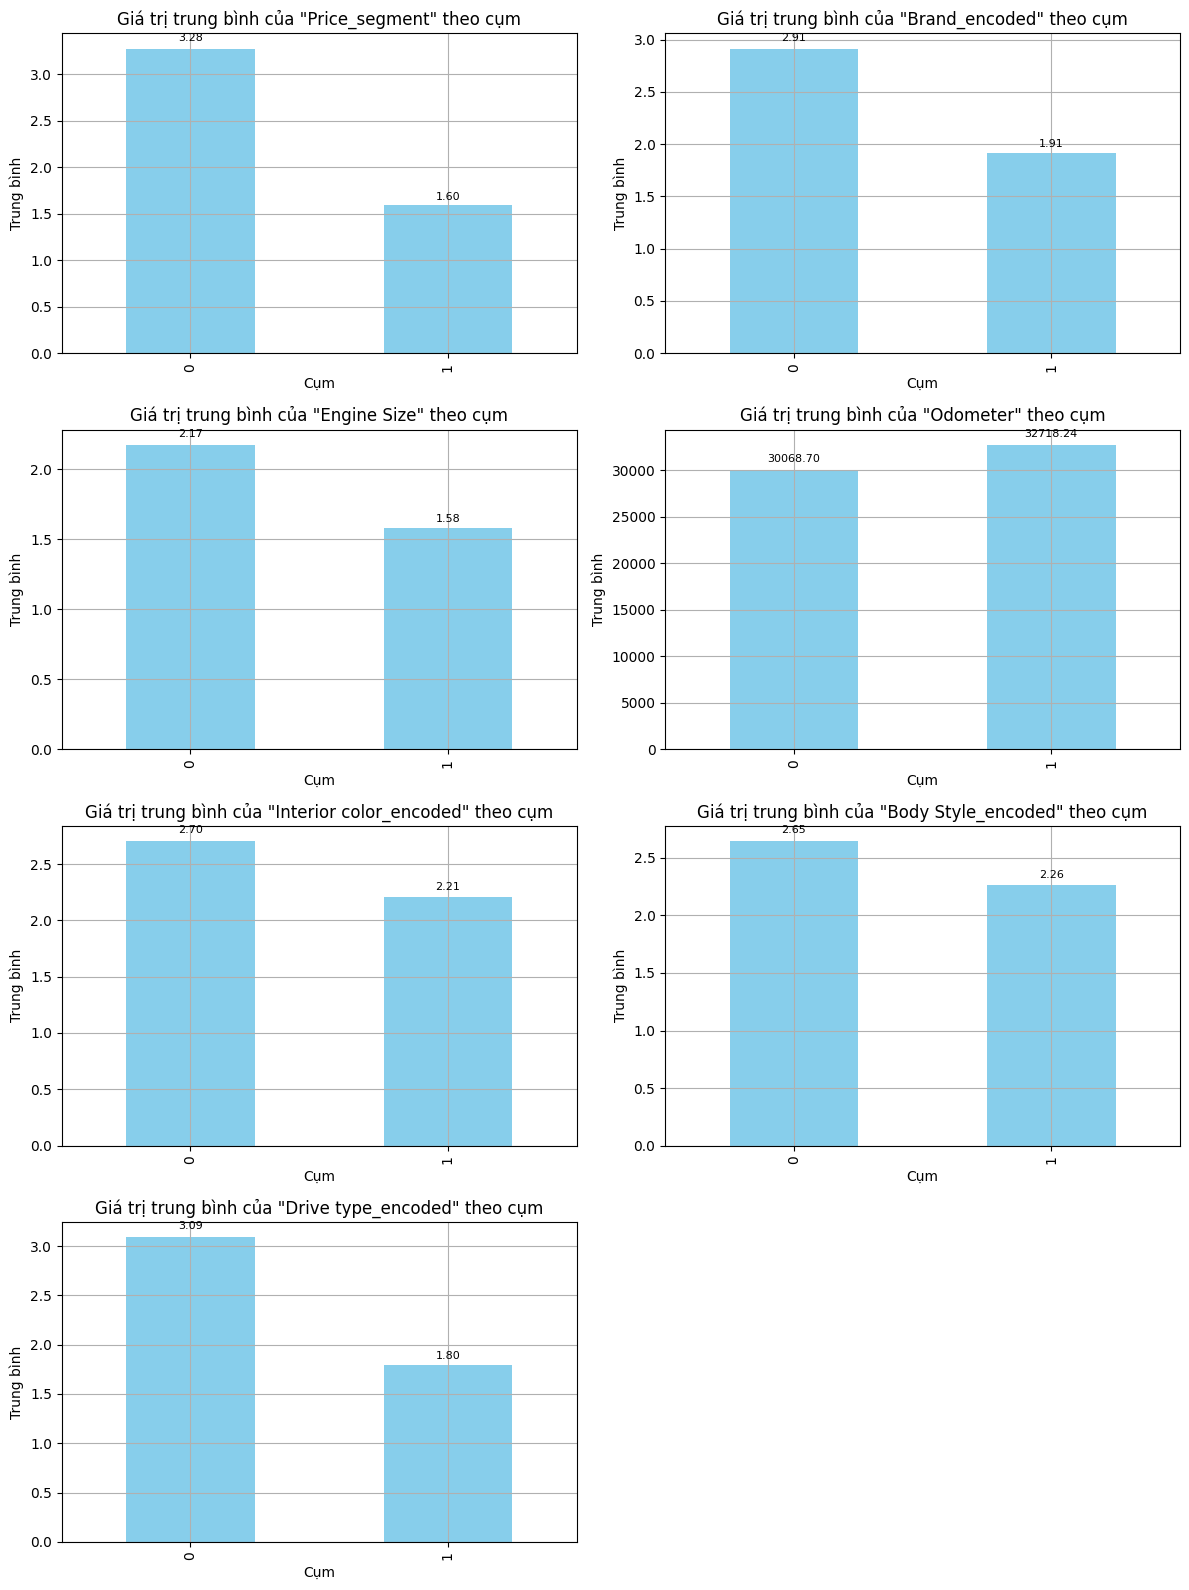

In [68]:

features = X.select_dtypes(include=['number']).columns.drop('Cluster')
means = X.groupby('Cluster')[features].mean()
# Số cột và hàng trong subplot
n_cols = 2
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

# Vẽ biểu đồ từng đặc trưng
for i, feature in enumerate(features):
    bars = means[feature].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Giá trị trung bình của "{feature}" theo cụm')
    axes[i].set_xlabel('Cụm')
    axes[i].set_ylabel('Trung bình')
    axes[i].grid(True)

    # Thêm giá trị lên cột
    for idx, value in enumerate(means[feature]):
        axes[i].text(idx, value + 0.02 * value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

# Ẩn subplot thừa nếu có
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Phân tích dữ liệu phân cụm bằng Gaussian Mixture Model (GMM)

## Thông tin chung

- Sử dụng mô hình **Gaussian Mixture Model (GMM)** để phân cụm dữ liệu.
- **GMM** cho phép mô hình hóa dữ liệu với nhiều phân phối chuẩn, giúp phân nhóm dữ liệu mà không giả định rằng các cụm phải có hình dạng cầu hoặc đều.
- Biểu đồ dưới đây trình bày **giá trị trung bình** của các thuộc tính trong từng cụm.

---

## Phân tích chi tiết các cụm

| Thuộc tính                     | Cụm 0 (Mean) | Cụm 1 (Mean) | Nhận xét |
|-------------------------------|--------------|--------------|----------|
| `Price_segment`               | **3.28**     | **1.60**     | Cụm 0 có giá trị trung bình cao hơn trong phân khúc giá. |
| `Brand_encoded`               | 2.95         | 1.91         | Cụm 0 có xu hướng chứa các thương hiệu cao cấp hơn. |
| `Engine Size`                 | 2.17         | 1.58         | Cụm 0 có động cơ lớn hơn, có thể là xe cao cấp hoặc mạnh mẽ hơn. |
| `Odometer`                    | 30,068       | 32,778       | Cụm 1 có số km đã đi cao hơn, có thể là xe đã qua sử dụng. |
| `Interior color_encoded`      | 2.70         | 2.21         | Cụm 0 sử dụng màu nội thất sang trọng hơn. |
| `Body Style_encoded`          | 2.55         | 2.26         | Cụm 0 có xu hướng sử dụng kiểu dáng xe đa dạng hoặc cao cấp hơn. |
| `Drive type_encoded`          | 3.09         | 1.80         | Cụm 0 sử dụng hệ dẫn động cao cấp (AWD, 4WD) nhiều hơn. |

---

## Kết luận

- **Cụm 0** đại diện cho nhóm xe:
  - Phân khúc giá cao
  - Thương hiệu cao cấp
  - Động cơ mạnh mẽ
  - Số km đi thấp hơn (xe mới hoặc ít sử dụng)
  - Nội thất sang trọng, kiểu dáng cao cấp

- **Cụm 1** đại diện cho nhóm xe:
  - Giá thấp hơn
  - Động cơ nhỏ, chạy nhiều km hơn
  - Xe có thể đã qua sử dụng nhiều và có tính năng phổ thông

Mô hình **GMM** đã phân nhóm dữ liệu theo một cách linh hoạt hơn, giúp xác định các phân phối chuẩn trong dữ liệu và cải thiện khả năng phân loại, điều này có thể hỗ trợ các tác vụ như **dự đoán giá trị**, **xây dựng các chiến lược tiếp thị** hoặc **phân loại xe** hiệu quả hơn.

---
